In [1]:
"""
===============================
Plot classification probability
===============================

Plot the classification probability for different classifiers. We use a 3 class dataset, and we 
classify it with a Support Vector classifier, L1 and L2 penalized logistic regression with either 
a One-Vs-Rest or multinomial setting, and Gaussian process classification.

Linear SVC is not a probabilistic classifier by default but it has a built-in calibration option 
enabled in this example (probability=True).

The logistic regression with One-Vs-Rest is not a multiclass classifier out of the box. As a result 
it has more trouble in separating class 2 and 3 than the other estimators.



"""

# Author: Alexandre Gramfort <alexandre.gramfort@inria.fr>
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm

from sklearn import datasets
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

import time

In [2]:
start_time = time.time()

iris = datasets.load_iris()
X = iris.data[:, 0:2]  # we only take the first two features for visualization
y = iris.target

n_features = X.shape[1]

C = 10
kernel = 1.0 * RBF([1.0, 1.0])  # for GPC

In [3]:
# Create different classifiers.
classifiers = {
    "L1 logistic": LogisticRegression(
        C=C, penalty="l1", solver="saga", multi_class="multinomial", max_iter=10000
    ),
    "L2 logistic (Multinomial)": LogisticRegression(
        C=C, penalty="l2", solver="saga", multi_class="multinomial", max_iter=10000
    ),
    "L2 logistic (OvR)": LogisticRegression(
        C=C, penalty="l2", solver="saga", multi_class="ovr", max_iter=10000
    ),
    "Linear SVC": SVC(kernel="linear", C=C, probability=True, random_state=0),
    "GPC": GaussianProcessClassifier(kernel),
}

n_classifiers = len(classifiers)
print(n_classifiers)

5


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 1 2 1 2 1 2 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1
 2 2 2 2 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 2 2 2 2
 2 2 1 1 2 2 2 2 1 2 1 2 2 2 2 1 1 2 2 2 2 2 2 1 2 2 2 1 2 2 2 1 2 2 2 1 2
 2 1]
Accuracy (train) for L1 logistic: 83.3% 
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 2 2 2 1 2 1 2 1 2 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1
 2 2 2 2 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 2 2 2 2
 2 2 1 1 2 2 2 2 1 2 1 2 2 2 2 1 1 2 2 2 2 2 2 1 2 2 2 1 2 2 2 1 2 2 2 1 2
 2 1]
Accuracy (train) for L2 logistic (Multinomial): 82.7% 
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 2 2 2 1 2 1 2 1 2 1 1 1 1 1 1 2 1 1 1 1 2 1 1 1
 2 2 2 2 1 1 1 1 1 1 0 2 2 1 1 1 1 2 1 1 1 1 1 2 1 1 2 1 2 2 2 2 1 2 2 2 2
 2 2 1 1 2 2 2 2 1 2 1 2 1 2 2 1 2 2 2 2 2 2 2 1 2 2 2 1 2 2 2 1 2 

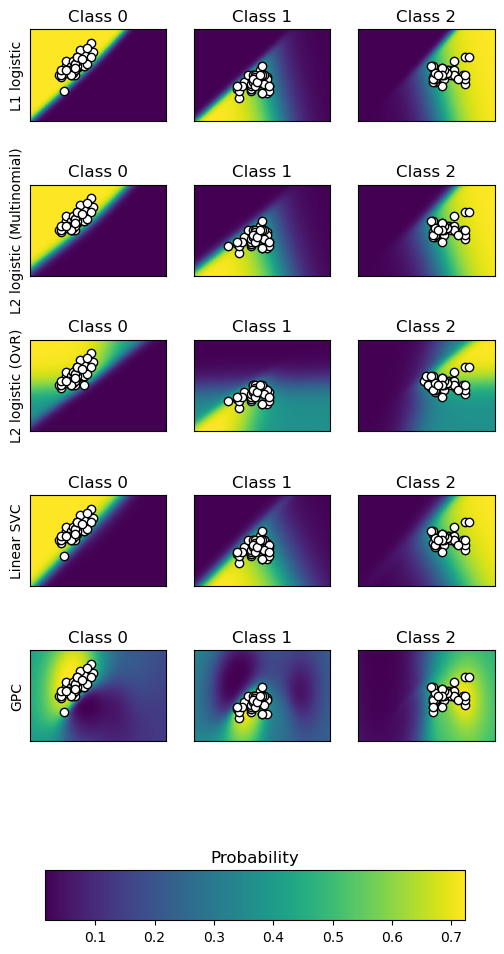

In [4]:
plt.figure(figsize=(3 * 2, n_classifiers * 2))
plt.subplots_adjust(bottom=0.2, top=0.95)

xx = np.linspace(3, 9, 100)
yy = np.linspace(1, 5, 100).T
xx, yy = np.meshgrid(xx, yy)
Xfull = np.c_[xx.ravel(), yy.ravel()]

for index, (name, classifier) in enumerate(classifiers.items()):
    classifier.fit(X, y)

    y_pred = classifier.predict(X)
    print(y_pred)
    accuracy = accuracy_score(y, y_pred)
    print("Accuracy (train) for %s: %0.1f%% " % (name, accuracy * 100))

    # View probabilities:
    probas = classifier.predict_proba(Xfull)
    n_classes = np.unique(y_pred).size
    for k in range(n_classes):
        plt.subplot(n_classifiers, n_classes, index * n_classes + k + 1)
        plt.title("Class %d" % k)
        if k == 0:
            plt.ylabel(name)
        imshow_handle = plt.imshow(
            probas[:, k].reshape((100, 100)), extent=(3, 9, 1, 5), origin="lower"
        )
        plt.xticks(())
        plt.yticks(())
        idx = y_pred == k
        if idx.any():
            plt.scatter(X[idx, 0], X[idx, 1], marker="o", c="w", edgecolor="k")

ax = plt.axes([0.15, 0.04, 0.7, 0.05])
plt.title("Probability")
plt.colorbar(imshow_handle, cax=ax, orientation="horizontal")

plt.show()

In [5]:
end_time = time.time()

runtime = end_time - start_time
print(f"\nTotal runtime: {runtime} seconds")


Total runtime: 0.956942081451416 seconds
